# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tf_env/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_env/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


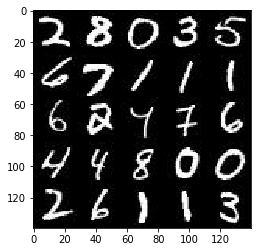

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

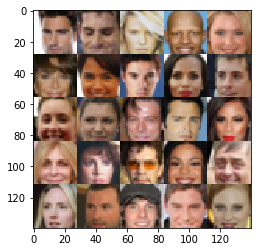

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tf_env/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_input')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'z_data')
    lr = tf.placeholder(tf.float32, name = 'learning_rate')
    
    return (input_real, input_z, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [35]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse = reuse):
        #First convolution layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides = 1, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.maximum(alpha*conv1, conv1)
        conv1 = tf.layers.average_pooling2d(conv1, pool_size = 2, strides = 2)
        #batch_size x 14 x 14 x 64
        
        #Second convolution layer
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides = 1, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training = True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        conv2 = tf.layers.average_pooling2d(conv2, pool_size = 2, strides = 2)
        #batch_size x 7 x 7 x 128
        
        #Third layer
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides = 1, padding = 'same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv3 = tf.layers.batch_normalization(conv3, training = True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        conv3 = tf.layers.average_pooling2d(conv3, pool_size = 2, strides = 1)
        #batch_size x 7 x 7 x 256
        
        #Flatten
        flat = tf.layers.flatten(conv3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [36]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # TODO: Implement Function
    alpha = 0.2
    
    # variable_scope will reuse the variables exactly when it is not training
    with tf.variable_scope('generator', reuse = not is_train):
        #Reshape z using a fully connexted layer
        z_reshaped = tf.layers.dense(z, 7*7*512)
        z_reshaped = tf.reshape(z_reshaped, (-1, 7, 7, 512))
        z_reshaped = tf.layers.batch_normalization(z_reshaped, training = is_train)
        z_reshaped = tf.maximum(z_reshaped * alpha, z_reshaped)
        #batch_size x 7 x 7 x 512
        
        
        #First convolution layer
        conv1 = tf.layers.conv2d_transpose(z_reshaped, 256, 5, strides = 2, padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv1 = tf.layers.batch_normalization(conv1, training = is_train)
        conv1 = tf.maximum(conv1 * alpha, conv1)
        #batch_size x 14 x 14 x 256
        
        
        #Second convolution layer
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 5, strides = 2, padding = 'same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        conv2 = tf.layers.batch_normalization(conv2, training = is_train)
        conv2 = tf.maximum(conv2 * alpha, conv2)
        #batch_size x 28 x 28 x 128
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(conv2, out_channel_dim, 5, strides=1, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        # batch_size x 28 x 28 x out_channel_dim 
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #generator output
    g_model = generator(input_z, out_channel_dim) 
    
    #discriminator output and logits for the real input
    d_model_real, d_logits_real = discriminator(input_real)
    
    #discriminator output and logits for the fake inputs generated by the generator
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #get trainable variables
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        
    #Figure out if the data is RGB or Gray and assign the channel dim. 
    width, height, channel_dim = data_shape[1], data_shape[2], data_shape[3]

    #inputs
    input_real, input_z, lr = model_inputs(width, height, channel_dim, z_dim)
        
    #loss
    d_loss, g_loss = model_loss(input_real, input_z, channel_dim)
    
    #optimization
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    #Count the batches and display generator output if count = 0 mod 100
    count = 0 
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                
                batch_images = batch_images * 2
                
                #Noise for the generator
                batch_z = np.random.normal(0, 0.5, size=(batch_size, z_dim))
                
                #run the optimizers
                _ = sess.run(d_opt, feed_dict = {input_real : batch_images, 
                                                 input_z : batch_z,
                                                 lr : learning_rate})
                _ = sess.run(g_opt, feed_dict = {input_real : batch_images, 
                                                 input_z : batch_z,
                                                 lr : learning_rate})
                
                if count % 5 == 0:
                    train_loss_d = d_loss.eval({input_real : batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step {}...".format(count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                #Show the generator images for a sample_z at every 100 batches. 
                if count % 100 == 0:
                    show_generator_output(sess, 25, input_z, channel_dim, data_image_mode)
            
            # Print the discriminator loss and generator loss at the end of each epoch. 
            train_loss_d = d_loss.eval({input_real : batch_images, input_z: batch_z})
            train_loss_g = g_loss.eval({input_z: batch_z})

            print("Epoch {}...".format(epoch_i),
                  "Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 5... Discriminator Loss: 0.0132... Generator Loss: 19.8729
Step 10... Discriminator Loss: 1.6550... Generator Loss: 7.7244
Step 15... Discriminator Loss: 5.0040... Generator Loss: 0.4213
Step 20... Discriminator Loss: 1.7102... Generator Loss: 2.6561
Step 25... Discriminator Loss: 0.6065... Generator Loss: 3.2815
Step 30... Discriminator Loss: 1.4856... Generator Loss: 0.5491
Step 35... Discriminator Loss: 1.4928... Generator Loss: 2.1344
Step 40... Discriminator Loss: 1.6014... Generator Loss: 0.6536
Step 45... Discriminator Loss: 1.4724... Generator Loss: 3.1468
Step 50... Discriminator Loss: 1.3560... Generator Loss: 1.6324
Step 55... Discriminator Loss: 1.2371... Generator Loss: 0.9748
Step 60... Discriminator Loss: 1.8370... Generator Loss: 0.2637
Step 65... Discriminator Loss: 1.3210... Generator Loss: 0.8764
Step 70... Discriminator Loss: 1.5460... Generator Loss: 1.6745
Step 75... Discriminator Loss: 1.6859... Generator Loss: 0.4534
Step 80... Discriminator Loss: 1.8087...

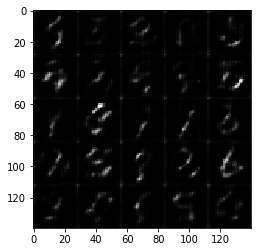

Step 105... Discriminator Loss: 1.3964... Generator Loss: 0.8371
Step 110... Discriminator Loss: 1.0146... Generator Loss: 0.8755
Step 115... Discriminator Loss: 1.7888... Generator Loss: 0.3782
Step 120... Discriminator Loss: 1.3065... Generator Loss: 0.7546
Step 125... Discriminator Loss: 1.4160... Generator Loss: 0.6358
Step 130... Discriminator Loss: 2.0514... Generator Loss: 0.2114
Step 135... Discriminator Loss: 1.2688... Generator Loss: 1.0981
Step 140... Discriminator Loss: 1.4052... Generator Loss: 0.6012
Step 145... Discriminator Loss: 1.6040... Generator Loss: 1.0063
Step 150... Discriminator Loss: 1.5717... Generator Loss: 0.3364
Step 155... Discriminator Loss: 1.3377... Generator Loss: 0.5204
Step 160... Discriminator Loss: 1.4698... Generator Loss: 1.2263
Step 165... Discriminator Loss: 1.2961... Generator Loss: 0.6015
Step 170... Discriminator Loss: 1.4613... Generator Loss: 1.4857
Step 175... Discriminator Loss: 1.2952... Generator Loss: 0.5418
Step 180... Discriminator

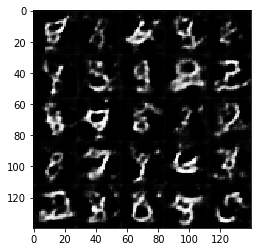

Step 205... Discriminator Loss: 1.3046... Generator Loss: 0.6927
Step 210... Discriminator Loss: 1.6092... Generator Loss: 1.8052
Step 215... Discriminator Loss: 1.1268... Generator Loss: 0.9801
Step 220... Discriminator Loss: 1.2321... Generator Loss: 0.9394
Step 225... Discriminator Loss: 1.6007... Generator Loss: 0.3184
Step 230... Discriminator Loss: 1.4479... Generator Loss: 1.5025
Step 235... Discriminator Loss: 1.2774... Generator Loss: 0.7429
Step 240... Discriminator Loss: 1.4886... Generator Loss: 1.5338
Step 245... Discriminator Loss: 1.2119... Generator Loss: 0.7671
Step 250... Discriminator Loss: 1.4542... Generator Loss: 0.4060
Step 255... Discriminator Loss: 1.3724... Generator Loss: 1.0318
Step 260... Discriminator Loss: 1.2521... Generator Loss: 0.8717
Step 265... Discriminator Loss: 2.0169... Generator Loss: 0.1913
Step 270... Discriminator Loss: 1.3036... Generator Loss: 0.6506
Step 275... Discriminator Loss: 1.2150... Generator Loss: 1.0589
Step 280... Discriminator

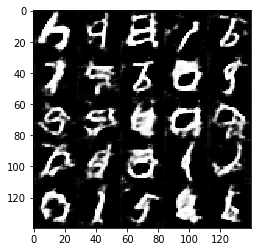

Step 305... Discriminator Loss: 1.3321... Generator Loss: 1.1651
Step 310... Discriminator Loss: 1.2529... Generator Loss: 0.9608
Step 315... Discriminator Loss: 1.4206... Generator Loss: 0.4185
Step 320... Discriminator Loss: 1.2380... Generator Loss: 0.8843
Step 325... Discriminator Loss: 1.2228... Generator Loss: 0.6809
Step 330... Discriminator Loss: 1.1961... Generator Loss: 1.0372
Step 335... Discriminator Loss: 1.5163... Generator Loss: 0.3369
Step 340... Discriminator Loss: 1.2052... Generator Loss: 0.9190
Step 345... Discriminator Loss: 1.4457... Generator Loss: 0.4506
Step 350... Discriminator Loss: 1.1385... Generator Loss: 1.7275
Step 355... Discriminator Loss: 1.1355... Generator Loss: 0.9085
Step 360... Discriminator Loss: 1.2156... Generator Loss: 0.7965
Step 365... Discriminator Loss: 1.9613... Generator Loss: 2.1148
Step 370... Discriminator Loss: 1.3226... Generator Loss: 1.0952
Step 375... Discriminator Loss: 1.2941... Generator Loss: 0.5097
Step 380... Discriminator

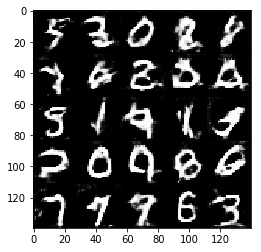

Step 405... Discriminator Loss: 1.3981... Generator Loss: 0.4200
Step 410... Discriminator Loss: 1.2791... Generator Loss: 1.0866
Step 415... Discriminator Loss: 1.1769... Generator Loss: 0.6917
Step 420... Discriminator Loss: 1.9837... Generator Loss: 2.1030
Step 425... Discriminator Loss: 1.3070... Generator Loss: 0.5047
Step 430... Discriminator Loss: 1.2624... Generator Loss: 0.5398
Step 435... Discriminator Loss: 1.1649... Generator Loss: 0.6787
Step 440... Discriminator Loss: 1.8130... Generator Loss: 1.8245
Step 445... Discriminator Loss: 1.2088... Generator Loss: 0.7811
Step 450... Discriminator Loss: 1.1578... Generator Loss: 0.6996
Step 455... Discriminator Loss: 1.3934... Generator Loss: 1.7250
Step 460... Discriminator Loss: 1.8224... Generator Loss: 0.2214
Step 465... Discriminator Loss: 1.1542... Generator Loss: 0.6534
Epoch 0... Discriminator Loss: 1.1701... Generator Loss: 0.8294
Step 470... Discriminator Loss: 1.1619... Generator Loss: 0.7776
Step 475... Discriminator 

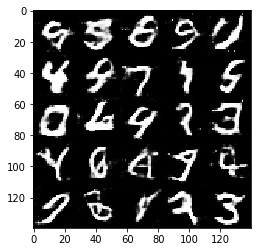

Step 505... Discriminator Loss: 1.1130... Generator Loss: 0.8506
Step 510... Discriminator Loss: 1.0382... Generator Loss: 0.9422
Step 515... Discriminator Loss: 1.6332... Generator Loss: 0.2824
Step 520... Discriminator Loss: 1.3602... Generator Loss: 0.4263
Step 525... Discriminator Loss: 1.2024... Generator Loss: 1.0296
Step 530... Discriminator Loss: 1.2042... Generator Loss: 0.6284
Step 535... Discriminator Loss: 1.4320... Generator Loss: 1.1825
Step 540... Discriminator Loss: 1.2783... Generator Loss: 0.7100
Step 545... Discriminator Loss: 1.2463... Generator Loss: 0.5351
Step 550... Discriminator Loss: 1.1422... Generator Loss: 0.7336
Step 555... Discriminator Loss: 1.4952... Generator Loss: 0.3571
Step 560... Discriminator Loss: 1.2193... Generator Loss: 0.6403
Step 565... Discriminator Loss: 1.0470... Generator Loss: 1.0010
Step 570... Discriminator Loss: 2.4044... Generator Loss: 0.1272
Step 575... Discriminator Loss: 1.0142... Generator Loss: 1.0524
Step 580... Discriminator

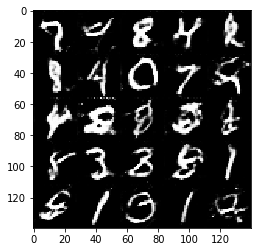

Step 605... Discriminator Loss: 1.1944... Generator Loss: 1.4732
Step 610... Discriminator Loss: 1.1500... Generator Loss: 0.8281
Step 615... Discriminator Loss: 1.2430... Generator Loss: 0.6023
Step 620... Discriminator Loss: 1.1309... Generator Loss: 1.0574
Step 625... Discriminator Loss: 1.8743... Generator Loss: 0.2670
Step 630... Discriminator Loss: 1.3841... Generator Loss: 0.4158
Step 635... Discriminator Loss: 1.1981... Generator Loss: 0.6626
Step 640... Discriminator Loss: 1.2533... Generator Loss: 0.5091
Step 645... Discriminator Loss: 1.8318... Generator Loss: 2.1632
Step 650... Discriminator Loss: 1.1619... Generator Loss: 0.8153
Step 655... Discriminator Loss: 1.1637... Generator Loss: 0.5819
Step 660... Discriminator Loss: 1.1449... Generator Loss: 1.2561
Step 665... Discriminator Loss: 1.6704... Generator Loss: 0.3011
Step 670... Discriminator Loss: 1.3077... Generator Loss: 0.5021
Step 675... Discriminator Loss: 1.0818... Generator Loss: 0.8674
Step 680... Discriminator

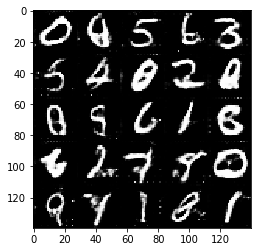

Step 705... Discriminator Loss: 1.3469... Generator Loss: 0.5102
Step 710... Discriminator Loss: 1.0616... Generator Loss: 1.0739
Step 715... Discriminator Loss: 1.1173... Generator Loss: 0.6413
Step 720... Discriminator Loss: 1.3655... Generator Loss: 0.4534
Step 725... Discriminator Loss: 1.6625... Generator Loss: 1.8142
Step 730... Discriminator Loss: 1.2755... Generator Loss: 0.5393
Step 735... Discriminator Loss: 1.2527... Generator Loss: 0.6488
Step 740... Discriminator Loss: 1.2193... Generator Loss: 1.1277
Step 745... Discriminator Loss: 1.1827... Generator Loss: 0.8113
Step 750... Discriminator Loss: 1.0847... Generator Loss: 0.7530
Step 755... Discriminator Loss: 1.0684... Generator Loss: 0.8178
Step 760... Discriminator Loss: 1.2075... Generator Loss: 0.9049
Step 765... Discriminator Loss: 1.5202... Generator Loss: 0.3421
Step 770... Discriminator Loss: 1.1868... Generator Loss: 0.6520
Step 775... Discriminator Loss: 1.0661... Generator Loss: 1.1626
Step 780... Discriminator

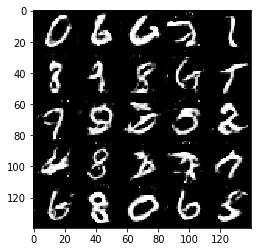

Step 805... Discriminator Loss: 1.3097... Generator Loss: 0.4795
Step 810... Discriminator Loss: 1.0629... Generator Loss: 1.0431
Step 815... Discriminator Loss: 1.4825... Generator Loss: 0.4095
Step 820... Discriminator Loss: 1.1287... Generator Loss: 0.9051
Step 825... Discriminator Loss: 1.2970... Generator Loss: 0.4765
Step 830... Discriminator Loss: 1.1145... Generator Loss: 0.9441
Step 835... Discriminator Loss: 1.1831... Generator Loss: 1.0812
Step 840... Discriminator Loss: 1.2590... Generator Loss: 0.7139
Step 845... Discriminator Loss: 1.0445... Generator Loss: 1.0381
Step 850... Discriminator Loss: 1.1549... Generator Loss: 1.3960
Step 855... Discriminator Loss: 1.3179... Generator Loss: 0.4584
Step 860... Discriminator Loss: 1.0093... Generator Loss: 1.0428
Step 865... Discriminator Loss: 1.0543... Generator Loss: 0.7742
Step 870... Discriminator Loss: 1.3245... Generator Loss: 2.1738
Step 875... Discriminator Loss: 1.5918... Generator Loss: 0.3427
Step 880... Discriminator

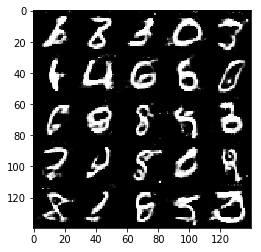

Step 905... Discriminator Loss: 1.2279... Generator Loss: 0.6500
Step 910... Discriminator Loss: 1.0293... Generator Loss: 1.0163
Step 915... Discriminator Loss: 1.2634... Generator Loss: 0.5684
Step 920... Discriminator Loss: 1.6350... Generator Loss: 2.0453
Step 925... Discriminator Loss: 1.0023... Generator Loss: 1.2724
Step 930... Discriminator Loss: 1.1344... Generator Loss: 0.7229
Step 935... Discriminator Loss: 1.0399... Generator Loss: 0.9823
Epoch 1... Discriminator Loss: 0.9909... Generator Loss: 0.9741


In [48]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 5... Discriminator Loss: 2.1750... Generator Loss: 0.7857
Step 10... Discriminator Loss: 1.4007... Generator Loss: 1.8337
Step 15... Discriminator Loss: 0.8487... Generator Loss: 1.6952
Step 20... Discriminator Loss: 0.9492... Generator Loss: 1.0827
Step 25... Discriminator Loss: 0.8261... Generator Loss: 2.5317
Step 30... Discriminator Loss: 0.5083... Generator Loss: 1.2092
Step 35... Discriminator Loss: 0.2836... Generator Loss: 2.1855
Step 40... Discriminator Loss: 0.7949... Generator Loss: 0.8825
Step 45... Discriminator Loss: 1.0094... Generator Loss: 0.9177
Step 50... Discriminator Loss: 1.0589... Generator Loss: 1.2881
Step 55... Discriminator Loss: 0.0848... Generator Loss: 3.6973
Step 60... Discriminator Loss: 0.1350... Generator Loss: 2.6230
Step 65... Discriminator Loss: 0.1538... Generator Loss: 3.1470
Step 70... Discriminator Loss: 1.2935... Generator Loss: 2.3943
Step 75... Discriminator Loss: 1.1411... Generator Loss: 0.8399
Step 80... Discriminator Loss: 2.0308... 

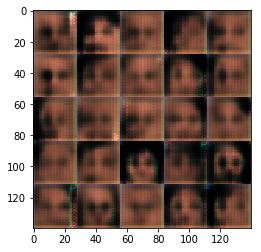

Step 105... Discriminator Loss: 1.7742... Generator Loss: 0.9275
Step 110... Discriminator Loss: 1.5204... Generator Loss: 0.8216
Step 115... Discriminator Loss: 1.4923... Generator Loss: 0.4285
Step 120... Discriminator Loss: 1.3644... Generator Loss: 0.8451
Step 125... Discriminator Loss: 1.3909... Generator Loss: 0.6782
Step 130... Discriminator Loss: 1.6375... Generator Loss: 1.1500
Step 135... Discriminator Loss: 1.1122... Generator Loss: 1.2452
Step 140... Discriminator Loss: 1.3749... Generator Loss: 0.9240
Step 145... Discriminator Loss: 1.4531... Generator Loss: 0.6333
Step 150... Discriminator Loss: 1.2759... Generator Loss: 1.1572
Step 155... Discriminator Loss: 1.3095... Generator Loss: 0.6354
Step 160... Discriminator Loss: 1.5880... Generator Loss: 0.4510
Step 165... Discriminator Loss: 1.3337... Generator Loss: 0.6295
Step 170... Discriminator Loss: 1.0504... Generator Loss: 0.8568
Step 175... Discriminator Loss: 2.0160... Generator Loss: 1.7600
Step 180... Discriminator

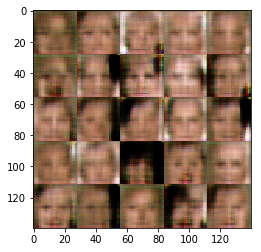

Step 205... Discriminator Loss: 1.1383... Generator Loss: 0.9682
Step 210... Discriminator Loss: 1.6041... Generator Loss: 0.7681
Step 215... Discriminator Loss: 1.4891... Generator Loss: 0.5821
Step 220... Discriminator Loss: 1.2026... Generator Loss: 0.7832
Step 225... Discriminator Loss: 1.6705... Generator Loss: 0.2998
Step 230... Discriminator Loss: 1.2651... Generator Loss: 0.7044
Step 235... Discriminator Loss: 1.5581... Generator Loss: 0.4037
Step 240... Discriminator Loss: 1.4032... Generator Loss: 0.4443
Step 245... Discriminator Loss: 1.1761... Generator Loss: 0.8532
Step 250... Discriminator Loss: 1.4824... Generator Loss: 0.8536
Step 255... Discriminator Loss: 1.6343... Generator Loss: 0.5071
Step 260... Discriminator Loss: 1.2807... Generator Loss: 0.6644
Step 265... Discriminator Loss: 1.4060... Generator Loss: 1.3131
Step 270... Discriminator Loss: 1.5634... Generator Loss: 0.8583
Step 275... Discriminator Loss: 1.0171... Generator Loss: 0.8413
Step 280... Discriminator

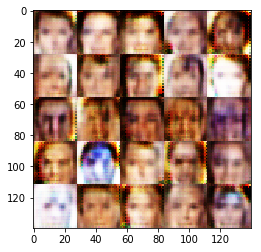

Step 305... Discriminator Loss: 1.4738... Generator Loss: 0.7905
Step 310... Discriminator Loss: 1.7528... Generator Loss: 0.3030
Step 315... Discriminator Loss: 1.3070... Generator Loss: 0.6224
Step 320... Discriminator Loss: 1.2204... Generator Loss: 0.8240
Step 325... Discriminator Loss: 1.1738... Generator Loss: 1.1482
Step 330... Discriminator Loss: 1.9104... Generator Loss: 0.2363
Step 335... Discriminator Loss: 1.5483... Generator Loss: 0.8371
Step 340... Discriminator Loss: 1.2788... Generator Loss: 0.5869
Step 345... Discriminator Loss: 1.5368... Generator Loss: 0.3482
Step 350... Discriminator Loss: 1.2125... Generator Loss: 0.8760
Step 355... Discriminator Loss: 1.1210... Generator Loss: 0.9925
Step 360... Discriminator Loss: 1.4195... Generator Loss: 0.6581
Step 365... Discriminator Loss: 1.4086... Generator Loss: 0.8169
Step 370... Discriminator Loss: 1.2831... Generator Loss: 0.8570
Step 375... Discriminator Loss: 1.4248... Generator Loss: 0.4109
Step 380... Discriminator

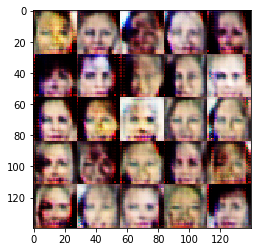

Step 405... Discriminator Loss: 2.0641... Generator Loss: 2.0028
Step 410... Discriminator Loss: 2.1558... Generator Loss: 2.6775
Step 415... Discriminator Loss: 1.1533... Generator Loss: 0.7023
Step 420... Discriminator Loss: 1.6114... Generator Loss: 0.4137
Step 425... Discriminator Loss: 1.2950... Generator Loss: 0.7080
Step 430... Discriminator Loss: 1.2679... Generator Loss: 1.2056
Step 435... Discriminator Loss: 2.1074... Generator Loss: 0.1886
Step 440... Discriminator Loss: 1.2164... Generator Loss: 0.9442
Step 445... Discriminator Loss: 1.3331... Generator Loss: 0.6983
Step 450... Discriminator Loss: 1.2223... Generator Loss: 0.6639
Step 455... Discriminator Loss: 1.4257... Generator Loss: 0.5361
Step 460... Discriminator Loss: 1.3957... Generator Loss: 0.6081
Step 465... Discriminator Loss: 1.2150... Generator Loss: 0.8488
Step 470... Discriminator Loss: 0.9786... Generator Loss: 0.8783
Step 475... Discriminator Loss: 1.1928... Generator Loss: 0.7699
Step 480... Discriminator

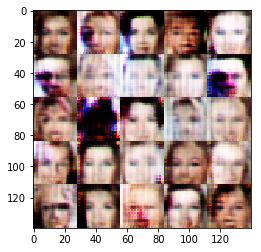

Step 505... Discriminator Loss: 1.2158... Generator Loss: 0.6162
Step 510... Discriminator Loss: 1.0725... Generator Loss: 0.9664
Step 515... Discriminator Loss: 1.7799... Generator Loss: 1.7149
Step 520... Discriminator Loss: 1.2084... Generator Loss: 0.9637
Step 525... Discriminator Loss: 1.6044... Generator Loss: 1.2315
Step 530... Discriminator Loss: 1.4432... Generator Loss: 0.6866
Step 535... Discriminator Loss: 0.9874... Generator Loss: 1.0340
Step 540... Discriminator Loss: 1.3747... Generator Loss: 0.8791
Step 545... Discriminator Loss: 1.2719... Generator Loss: 0.4903
Step 550... Discriminator Loss: 1.1592... Generator Loss: 1.2533
Step 555... Discriminator Loss: 1.2497... Generator Loss: 1.1475
Step 560... Discriminator Loss: 1.2875... Generator Loss: 0.7316
Step 565... Discriminator Loss: 1.1561... Generator Loss: 0.8825
Step 570... Discriminator Loss: 2.3586... Generator Loss: 2.4490
Step 575... Discriminator Loss: 1.4141... Generator Loss: 0.5618
Step 580... Discriminator

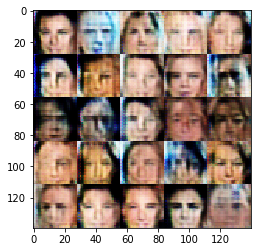

Step 605... Discriminator Loss: 2.0625... Generator Loss: 1.8385
Step 610... Discriminator Loss: 1.5253... Generator Loss: 0.5614
Step 615... Discriminator Loss: 1.0685... Generator Loss: 1.1989
Step 620... Discriminator Loss: 1.8232... Generator Loss: 0.2602
Step 625... Discriminator Loss: 0.9993... Generator Loss: 0.8880
Step 630... Discriminator Loss: 0.9398... Generator Loss: 1.1216
Step 635... Discriminator Loss: 1.5184... Generator Loss: 0.4429
Step 640... Discriminator Loss: 1.5371... Generator Loss: 0.3886
Step 645... Discriminator Loss: 1.3115... Generator Loss: 0.6415
Step 650... Discriminator Loss: 1.1985... Generator Loss: 0.7664
Step 655... Discriminator Loss: 1.4613... Generator Loss: 1.4627
Step 660... Discriminator Loss: 1.2976... Generator Loss: 0.6706
Step 665... Discriminator Loss: 1.3912... Generator Loss: 0.6345
Step 670... Discriminator Loss: 1.1978... Generator Loss: 0.5745
Step 675... Discriminator Loss: 1.3105... Generator Loss: 0.9631
Step 680... Discriminator

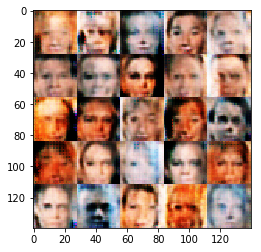

Step 705... Discriminator Loss: 1.1262... Generator Loss: 0.9063
Step 710... Discriminator Loss: 1.3254... Generator Loss: 0.4270
Step 715... Discriminator Loss: 1.5429... Generator Loss: 0.3361
Step 720... Discriminator Loss: 1.9854... Generator Loss: 1.0730
Step 725... Discriminator Loss: 1.3520... Generator Loss: 0.4722
Step 730... Discriminator Loss: 1.5723... Generator Loss: 0.6036
Step 735... Discriminator Loss: 1.4815... Generator Loss: 0.4640
Step 740... Discriminator Loss: 1.3516... Generator Loss: 0.5504
Step 745... Discriminator Loss: 1.1803... Generator Loss: 0.9822
Step 750... Discriminator Loss: 1.0991... Generator Loss: 1.0393
Step 755... Discriminator Loss: 1.0626... Generator Loss: 0.8307
Step 760... Discriminator Loss: 1.9956... Generator Loss: 0.3301
Step 765... Discriminator Loss: 1.2333... Generator Loss: 0.7105
Step 770... Discriminator Loss: 1.4957... Generator Loss: 1.3149
Step 775... Discriminator Loss: 1.5500... Generator Loss: 0.4668
Step 780... Discriminator

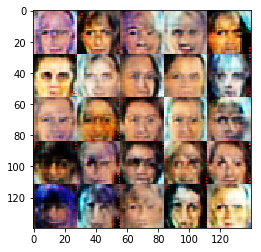

Step 805... Discriminator Loss: 1.0584... Generator Loss: 1.0460
Step 810... Discriminator Loss: 1.2401... Generator Loss: 0.9120
Step 815... Discriminator Loss: 1.2706... Generator Loss: 0.5397
Step 820... Discriminator Loss: 1.2633... Generator Loss: 1.0127
Step 825... Discriminator Loss: 1.4346... Generator Loss: 1.2039
Step 830... Discriminator Loss: 1.3739... Generator Loss: 0.7213
Step 835... Discriminator Loss: 1.4820... Generator Loss: 0.9154
Step 840... Discriminator Loss: 1.4469... Generator Loss: 0.4889
Step 845... Discriminator Loss: 1.3048... Generator Loss: 0.9175
Step 850... Discriminator Loss: 1.4789... Generator Loss: 0.7980
Step 855... Discriminator Loss: 1.2323... Generator Loss: 1.0487
Step 860... Discriminator Loss: 1.2339... Generator Loss: 0.9772
Step 865... Discriminator Loss: 1.4124... Generator Loss: 1.1128
Step 870... Discriminator Loss: 1.2362... Generator Loss: 0.9196
Step 875... Discriminator Loss: 1.2532... Generator Loss: 0.7062
Step 880... Discriminator

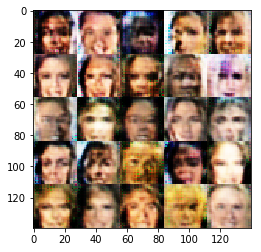

Step 905... Discriminator Loss: 1.2135... Generator Loss: 0.7108
Step 910... Discriminator Loss: 1.5547... Generator Loss: 1.0146
Step 915... Discriminator Loss: 1.5680... Generator Loss: 0.3834
Step 920... Discriminator Loss: 1.1866... Generator Loss: 0.9189
Step 925... Discriminator Loss: 1.3212... Generator Loss: 0.6757
Step 930... Discriminator Loss: 1.3830... Generator Loss: 0.4992
Step 935... Discriminator Loss: 1.5535... Generator Loss: 1.0225
Step 940... Discriminator Loss: 1.2417... Generator Loss: 0.7948
Step 945... Discriminator Loss: 1.3193... Generator Loss: 0.5512
Step 950... Discriminator Loss: 1.4343... Generator Loss: 1.3442
Step 955... Discriminator Loss: 1.4469... Generator Loss: 0.5782
Step 960... Discriminator Loss: 1.3997... Generator Loss: 0.7469
Step 965... Discriminator Loss: 1.5432... Generator Loss: 0.4723
Step 970... Discriminator Loss: 1.3328... Generator Loss: 0.7884
Step 975... Discriminator Loss: 1.3138... Generator Loss: 0.7283
Step 980... Discriminator

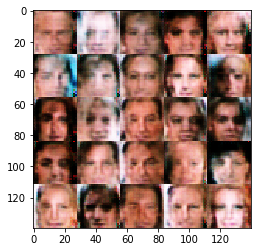

Step 1005... Discriminator Loss: 1.2911... Generator Loss: 1.5028
Step 1010... Discriminator Loss: 1.2882... Generator Loss: 0.7055
Step 1015... Discriminator Loss: 1.3364... Generator Loss: 0.5386
Step 1020... Discriminator Loss: 1.2892... Generator Loss: 0.4372
Step 1025... Discriminator Loss: 1.4086... Generator Loss: 0.5505
Step 1030... Discriminator Loss: 1.2747... Generator Loss: 1.0802
Step 1035... Discriminator Loss: 1.4209... Generator Loss: 0.7881
Step 1040... Discriminator Loss: 1.2913... Generator Loss: 0.8136
Step 1045... Discriminator Loss: 1.3732... Generator Loss: 0.6236
Step 1050... Discriminator Loss: 1.3405... Generator Loss: 0.5916
Step 1055... Discriminator Loss: 1.4487... Generator Loss: 0.4518
Step 1060... Discriminator Loss: 1.2706... Generator Loss: 0.7128
Step 1065... Discriminator Loss: 1.3399... Generator Loss: 0.9706
Step 1070... Discriminator Loss: 1.2722... Generator Loss: 0.8427
Step 1075... Discriminator Loss: 1.3033... Generator Loss: 0.7303
Step 1080.

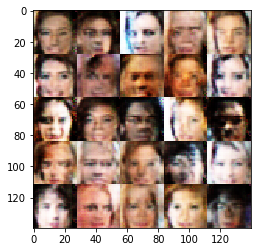

Step 1105... Discriminator Loss: 1.3342... Generator Loss: 0.8203
Step 1110... Discriminator Loss: 1.3412... Generator Loss: 0.5893
Step 1115... Discriminator Loss: 1.6022... Generator Loss: 0.5987
Step 1120... Discriminator Loss: 1.4914... Generator Loss: 0.5419
Step 1125... Discriminator Loss: 0.9787... Generator Loss: 1.1209
Step 1130... Discriminator Loss: 1.2587... Generator Loss: 0.8622
Step 1135... Discriminator Loss: 1.2397... Generator Loss: 0.8726
Step 1140... Discriminator Loss: 1.2907... Generator Loss: 0.9125
Step 1145... Discriminator Loss: 1.4313... Generator Loss: 1.0452
Step 1150... Discriminator Loss: 1.2727... Generator Loss: 0.7818
Step 1155... Discriminator Loss: 1.3521... Generator Loss: 0.6149
Step 1160... Discriminator Loss: 1.4436... Generator Loss: 0.5685
Step 1165... Discriminator Loss: 1.4127... Generator Loss: 0.4658
Step 1170... Discriminator Loss: 1.5179... Generator Loss: 1.2324
Step 1175... Discriminator Loss: 1.2913... Generator Loss: 0.5453
Step 1180.

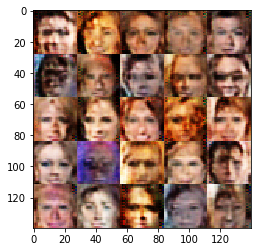

Step 1205... Discriminator Loss: 1.2078... Generator Loss: 0.8031
Step 1210... Discriminator Loss: 1.5080... Generator Loss: 0.5482
Step 1215... Discriminator Loss: 1.3344... Generator Loss: 0.7627
Step 1220... Discriminator Loss: 1.2996... Generator Loss: 1.3337
Step 1225... Discriminator Loss: 1.5205... Generator Loss: 0.4083
Step 1230... Discriminator Loss: 1.2910... Generator Loss: 0.9062
Step 1235... Discriminator Loss: 1.4074... Generator Loss: 0.9330
Step 1240... Discriminator Loss: 1.3106... Generator Loss: 0.8880
Step 1245... Discriminator Loss: 1.3836... Generator Loss: 0.6558
Step 1250... Discriminator Loss: 1.3772... Generator Loss: 0.6155
Step 1255... Discriminator Loss: 1.3477... Generator Loss: 0.7210
Step 1260... Discriminator Loss: 1.2366... Generator Loss: 0.8136
Step 1265... Discriminator Loss: 1.5502... Generator Loss: 0.7077
Step 1270... Discriminator Loss: 1.3484... Generator Loss: 0.6478
Step 1275... Discriminator Loss: 1.2023... Generator Loss: 0.8183
Step 1280.

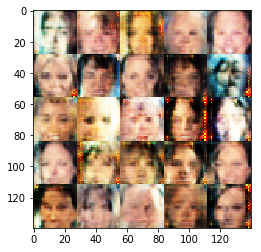

Step 1305... Discriminator Loss: 1.1487... Generator Loss: 1.4820
Step 1310... Discriminator Loss: 1.1603... Generator Loss: 0.8047
Step 1315... Discriminator Loss: 1.4471... Generator Loss: 0.4971
Step 1320... Discriminator Loss: 1.3231... Generator Loss: 0.6469
Step 1325... Discriminator Loss: 1.2970... Generator Loss: 0.6582
Step 1330... Discriminator Loss: 1.2885... Generator Loss: 0.7762
Step 1335... Discriminator Loss: 1.2688... Generator Loss: 0.6595
Step 1340... Discriminator Loss: 1.5934... Generator Loss: 0.3409
Step 1345... Discriminator Loss: 1.1211... Generator Loss: 0.8762
Step 1350... Discriminator Loss: 1.3803... Generator Loss: 0.6189
Step 1355... Discriminator Loss: 1.3057... Generator Loss: 0.6216
Step 1360... Discriminator Loss: 1.4310... Generator Loss: 0.5275
Step 1365... Discriminator Loss: 1.3283... Generator Loss: 0.8451
Step 1370... Discriminator Loss: 1.3850... Generator Loss: 0.7480
Step 1375... Discriminator Loss: 1.2166... Generator Loss: 0.7529
Step 1380.

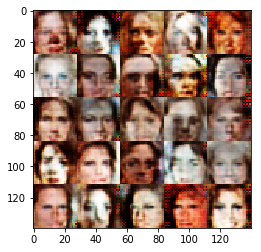

Step 1405... Discriminator Loss: 1.3290... Generator Loss: 0.5560
Step 1410... Discriminator Loss: 1.3303... Generator Loss: 0.7938
Step 1415... Discriminator Loss: 1.4342... Generator Loss: 0.8367
Step 1420... Discriminator Loss: 1.4690... Generator Loss: 0.7956
Step 1425... Discriminator Loss: 1.4892... Generator Loss: 0.4821
Step 1430... Discriminator Loss: 1.3668... Generator Loss: 0.7096
Step 1435... Discriminator Loss: 1.3842... Generator Loss: 0.6506
Step 1440... Discriminator Loss: 1.5150... Generator Loss: 0.4515
Step 1445... Discriminator Loss: 1.3744... Generator Loss: 0.8416
Step 1450... Discriminator Loss: 1.5432... Generator Loss: 0.4430
Step 1455... Discriminator Loss: 1.2690... Generator Loss: 0.6926
Step 1460... Discriminator Loss: 1.3999... Generator Loss: 0.8709
Step 1465... Discriminator Loss: 1.3174... Generator Loss: 0.9722
Step 1470... Discriminator Loss: 1.3371... Generator Loss: 0.7933
Step 1475... Discriminator Loss: 1.4512... Generator Loss: 0.9672
Step 1480.

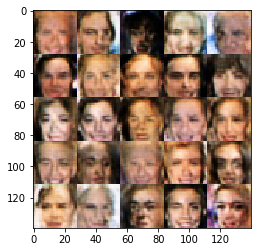

Step 1505... Discriminator Loss: 1.4316... Generator Loss: 0.4771
Step 1510... Discriminator Loss: 1.3744... Generator Loss: 1.0496
Step 1515... Discriminator Loss: 1.4223... Generator Loss: 0.7737
Step 1520... Discriminator Loss: 1.2386... Generator Loss: 0.8245
Step 1525... Discriminator Loss: 1.2347... Generator Loss: 0.8507
Step 1530... Discriminator Loss: 1.4438... Generator Loss: 0.5650
Step 1535... Discriminator Loss: 1.3231... Generator Loss: 0.8341
Step 1540... Discriminator Loss: 1.5424... Generator Loss: 1.3716
Step 1545... Discriminator Loss: 1.3044... Generator Loss: 0.9168
Step 1550... Discriminator Loss: 1.4409... Generator Loss: 0.5021
Step 1555... Discriminator Loss: 1.2676... Generator Loss: 0.6229
Step 1560... Discriminator Loss: 1.3154... Generator Loss: 0.7404
Step 1565... Discriminator Loss: 1.3493... Generator Loss: 0.6416
Step 1570... Discriminator Loss: 1.2271... Generator Loss: 0.9785
Step 1575... Discriminator Loss: 1.4191... Generator Loss: 0.5129
Step 1580.

In [40]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.